In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-tuner --upgrade

# **Part B: Regression Problem**

In [51]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [52]:
import time
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

In [53]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [54]:
df = pd.read_csv('/content/drive/MyDrive/CZ4042/hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [55]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    print("---Feature: %s ---" % name)
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string, divisor):
    print("---Feature: %s ---" % name)
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)
    print("this is vocab size ", lookup.vocabulary_size())
    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    
    num_categories = len(df[name].unique())
    print("this is num of categories ",num_categories)
    input_dim = lookup.vocabulary_size()
    output_dim = int(np.floor(num_categories//divisor))
    print("this is input dim ", input_dim, " and output dim ", output_dim)

    encoded_cat_embedding = keras.layers.Embedding(input_dim, output_dim, name=name+'-Embedding')(encoded_feature)
    encoded_cat_vec = keras.layers.Flatten(name='Flatten'+name)(encoded_cat_embedding)
    return encoded_cat_vec


In [56]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()))



In [57]:
df = df.drop(["full_address", "nearest_stn"], axis=1)
df.head()

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


# **Q2**
**Neural networks offer much more than fundamental machine learning algorithms. In this part of
the assignment, we will investigate one of its advantages: the use of trainable embeddings. Also,
we will learn how to set up a quick and convenient way of tuning your neural network models.
Instead of using one-hot encoding, an alternative approach is to use embeddings to encode
categorical variables. Such an approach utilises the ability of neural networks to learn richer
representations1 of the data – an edge it has over traditional ML models.**

In [58]:
batch_size = 256

####**a) Further split the data from year 2020 and before (i.e. those not in test set) by using data from year 2020 as validation set and the rest as the training set.**

In [59]:
# Split data

train_dataframe = df[df.year < 2020].reset_index(drop=True)
val_dataframe = df[(2019 < df.year) & (df.year < 2021)].reset_index(drop=True)
test_dataframe = df[df.year > 2020].reset_index(drop=True)

len(train_dataframe), len(val_dataframe),len(test_dataframe)

(64057, 23313, 46042)

####**b) For each categorical variable, replace the one-hot encoding with the layer tf.keras.layers.Embedding(). Set output_dim = floor(num_categories//divisor). ‘num_categories’ refers to the number of categories in the categorical variable. ‘divisor’ is a parameter which we will tune later (Hint: You will still need the lookup classes from Q1b. Read the documentation to find out what to change.) The Embedding layer produces a 2D output (3D, including batch), which cannot be concatenated with the other features. Add a Flatten layer to resolve this.**

One-hot-encoding has some disadvantages which can be tackled by using embeddings. Firstly, for some high cardinality categories, it will produce a huge binary space for shear amount of features. Secondly, one-hot-encoding is not capable of capturing relationships between the categories. With the use of embedding, we only use a smaller dense space by defining the size of embedding space and forcing model to learn a useful presentation.

In [60]:
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [61]:
def encodeInputFeature(categoricalDict, numericList, divisor):
  all_inputs = []
  all_features = []
  for cat, typ in categoricalDict.items():
    encoded_cat = keras.Input(shape=(1,), name=cat, dtype=typ)
    all_inputs.append(encoded_cat)
    if typ == "int64":
      all_features.append(encode_categorical_feature(encoded_cat, cat, train_ds, False, divisor))
    else:
      all_features.append(encode_categorical_feature(encoded_cat, cat, train_ds, True, divisor))
  for num in numericList:
    encoded_num = keras.Input(shape=(1,), name=num)
    all_inputs.append(encoded_num)
    all_features.append(encode_numerical_feature(encoded_num, num, train_ds))
  return all_inputs, layers.concatenate(all_features)

In [62]:
default_divisor = 1
categoricalDict = {
    "month": "int64",
    "flat_model_type": "string",
    "storey_range": "string"
}
numericList = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]

all_inputs, all_features = encodeInputFeature(categoricalDict, numericList, default_divisor)

---Feature: month ---
this is vocab size  13
this is num of categories  12
this is input dim  13  and output dim  12
---Feature: flat_model_type ---
this is vocab size  42
this is num of categories  44
this is input dim  42  and output dim  44
---Feature: storey_range ---
this is vocab size  18
this is num of categories  17
this is input dim  18  and output dim  17
---Feature: dist_to_nearest_stn ---
---Feature: dist_to_dhoby ---
---Feature: degree_centrality ---
---Feature: eigenvector_centrality ---
---Feature: remaining_lease_years ---
---Feature: floor_area_sqm ---


In [63]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dense(1, activation="linear")(x)

model = keras.Model(all_inputs, x)

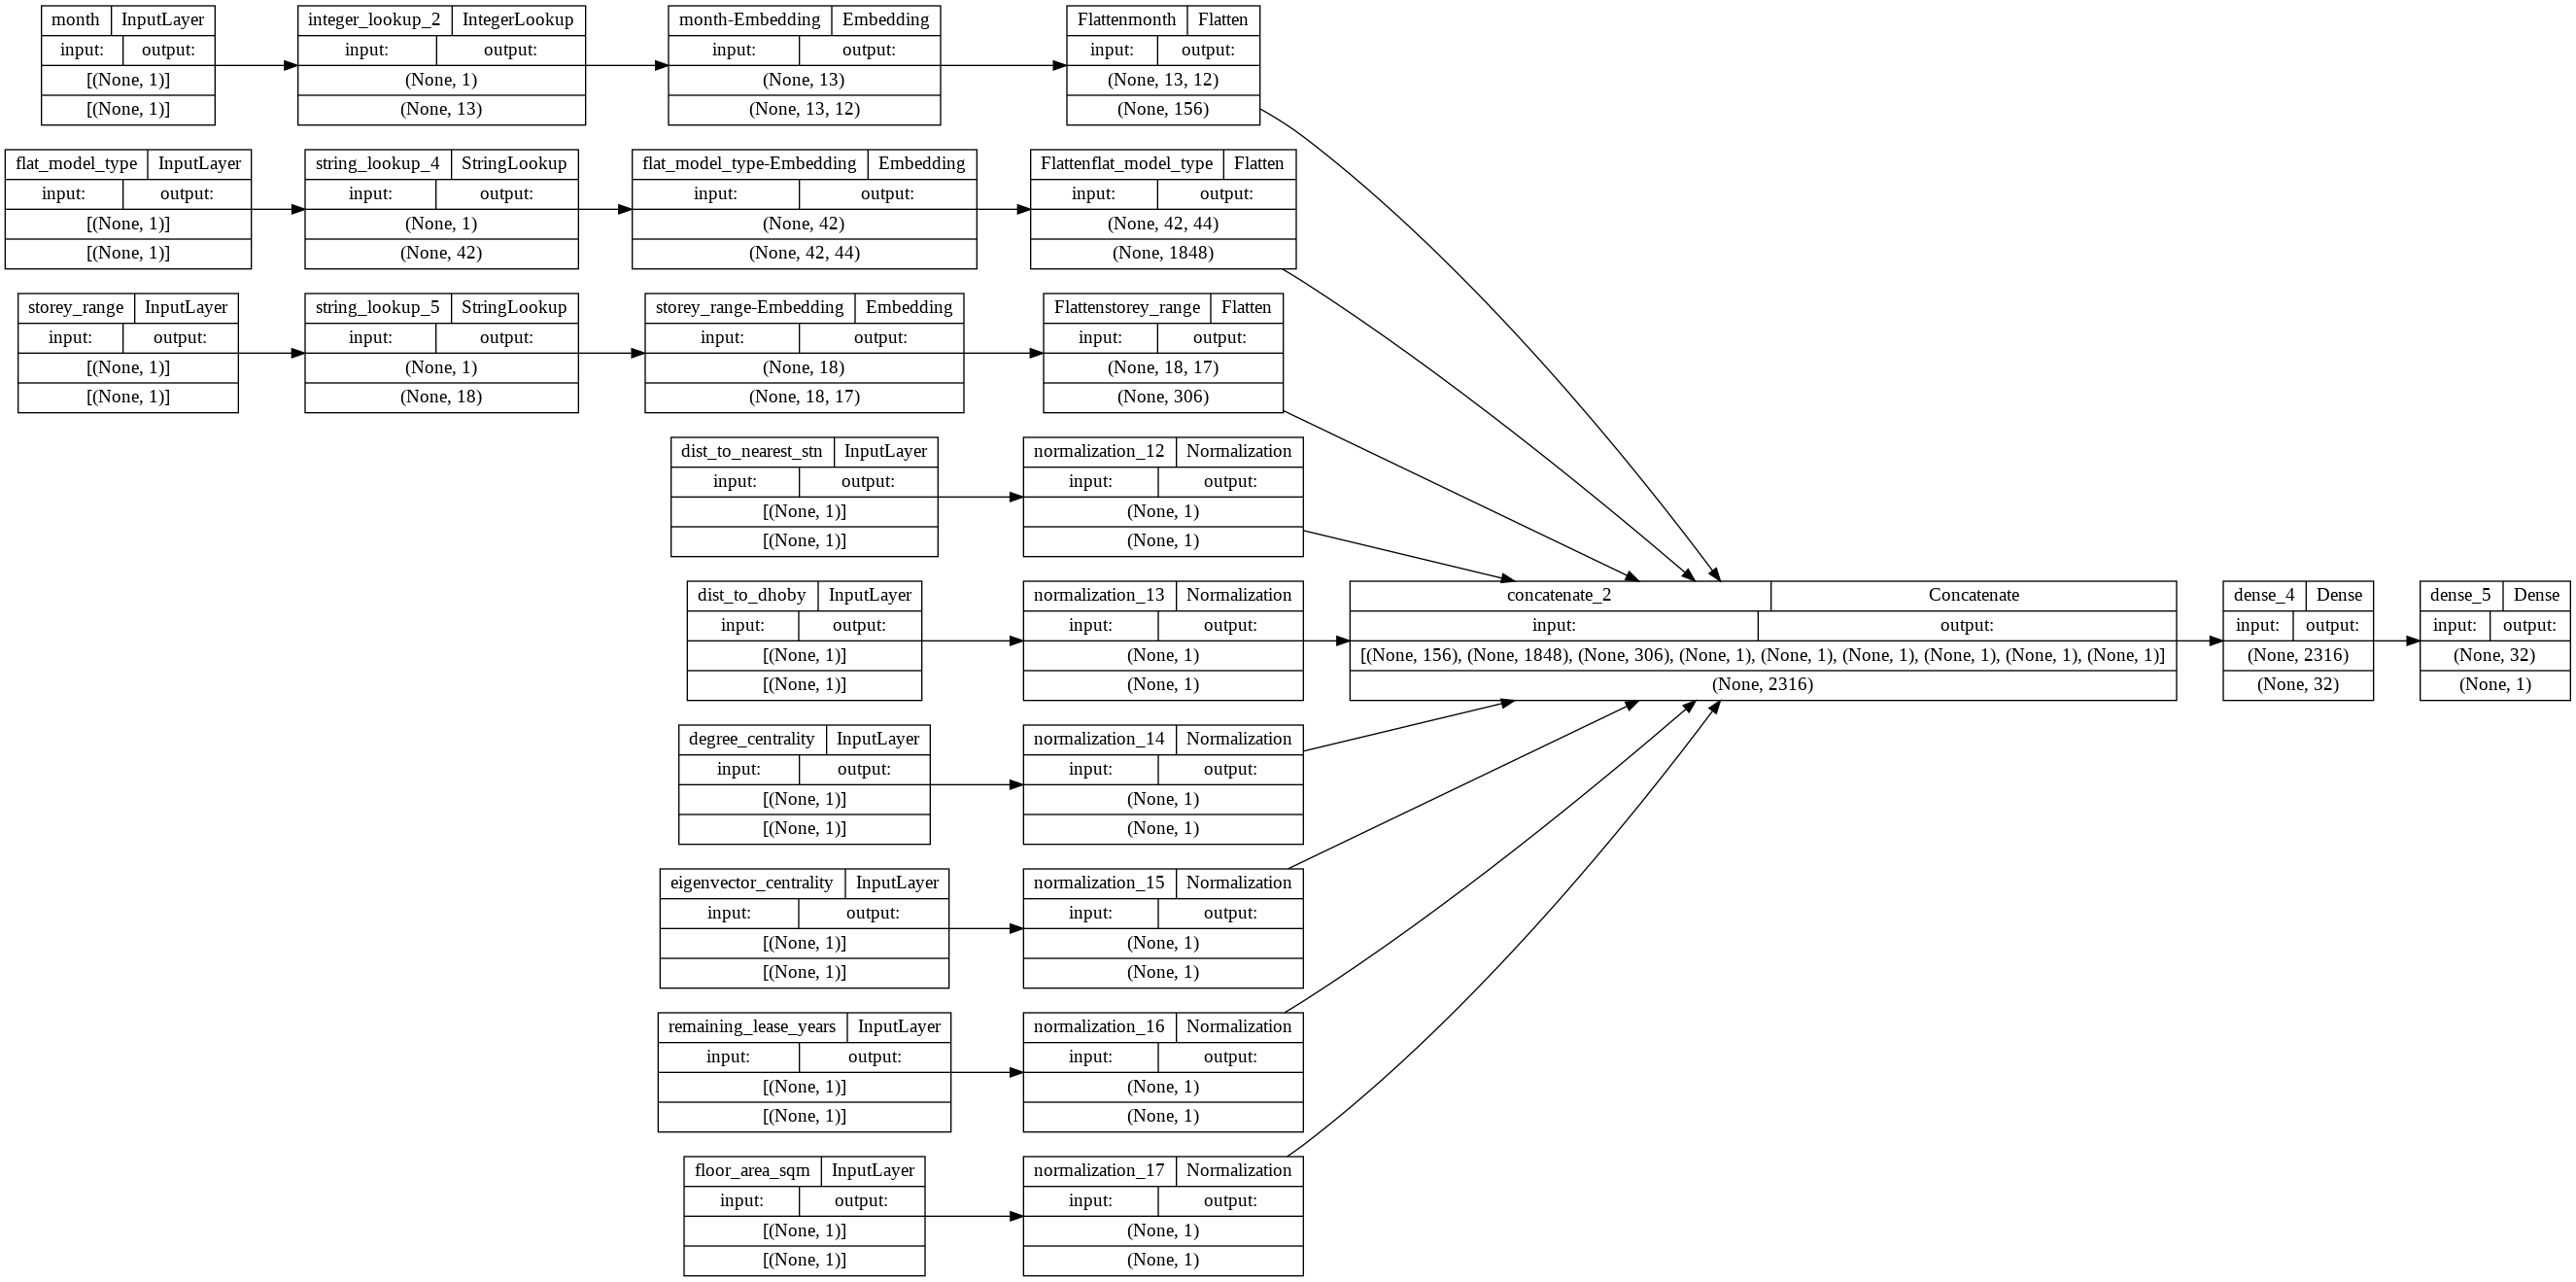

In [64]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

####**c) Via a callback, introduce early stopping (based on val_loss, with patience of 10 epochs) to the model. Using this as a reference, use KerasTuner (with the RandomSearch algorithm) to tune the model on the validation set, according to the following ranges:**
- **Number of neurons: min=4, max=32, step=4**
- **Learning rate: min=1e-4, max=2e-1, sampling=’log’**
- **Divisor: min=1, max=2, step=1**
- **Run 10 iterations of parameter search (i.e. max_trials=10), each for 50 epochs
and report the best set of hyperparameters (based on validation accuracy).**

In [87]:
import keras_tuner
def build_model(hp):
    categoricalDict = {
        "month": "int64",
        "flat_model_type": "string",
        "storey_range": "string"
    }
    numericList = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]
    all_inputs, all_features = encodeInputFeature(categoricalDict, numericList, divisor = hp.Int("divisor", min_value=1, max_value=2, step=1))

    x = layers.Dense(units=hp.Int("units", min_value=4, max_value=32, step=4), activation="relu",)(all_features)
    x = layers.Dense(1, activation="linear")(x)
    
    model = keras.Model(all_inputs, x)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=2e-1, sampling='log')),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[r2, tf.keras.metrics.RootMeanSquaredError()])
    return model

In [88]:
from kerastuner.tuners import RandomSearch

max_trials = 10
epoch = 50

tuner = RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    overwrite=True,
    max_trials=max_trials,
    directory='random_search',
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=[callback])

best_model = tuner.get_best_models(1)[0]

Trial 10 Complete [00h 00m 24s]
val_loss: 228450598912.0

Best val_loss So Far: 10871548928.0
Total elapsed time: 00h 04m 38s
---Feature: month ---
this is vocab size  13
this is num of categories  12
this is input dim  13  and output dim  6
---Feature: flat_model_type ---
this is vocab size  44
this is num of categories  44
this is input dim  44  and output dim  22
---Feature: storey_range ---
this is vocab size  18
this is num of categories  17
this is input dim  18  and output dim  8
---Feature: dist_to_nearest_stn ---
---Feature: dist_to_dhoby ---
---Feature: degree_centrality ---
---Feature: eigenvector_centrality ---
---Feature: remaining_lease_years ---
---Feature: floor_area_sqm ---


In [89]:
tuner.results_summary()

Results summary
Results in random_search/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
divisor: 2
units: 12
learning_rate: 0.19475490890173586
Score: 10871548928.0
Trial summary
Hyperparameters:
divisor: 2
units: 12
learning_rate: 0.19148940827737515
Score: 11238687744.0
Trial summary
Hyperparameters:
divisor: 1
units: 8
learning_rate: 0.1394113396524723
Score: 13125362688.0
Trial summary
Hyperparameters:
divisor: 2
units: 12
learning_rate: 0.11822407720959914
Score: 19310206976.0
Trial summary
Hyperparameters:
divisor: 2
units: 20
learning_rate: 0.12427649139617275
Score: 20549574656.0
Trial summary
Hyperparameters:
divisor: 2
units: 24
learning_rate: 0.012902274983730273
Score: 23843168256.0
Trial summary
Hyperparameters:
divisor: 1
units: 8
learning_rate: 0.04081876764438811
Score: 23949787136.0
Trial summary
Hyperparameters:
divisor: 1
units: 4
learning_rate: 0.0013830701281109042
Score: 222300045312.0
Trial summary
Hyperparameters:
divisor: 2
units: 8
lear

MSE is mean squared error, so if the model predicts the price with a 10k error, the MSE is 100 million. Therefore, we use RMSE for the metric for better presentation.

In [90]:
# Get best combination of hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

In [91]:
best_hp.get_config()

{'space': [{'class_name': 'Int',
   'config': {'name': 'divisor',
    'default': None,
    'conditions': [],
    'min_value': 1,
    'max_value': 2,
    'step': 1,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units',
    'default': None,
    'conditions': [],
    'min_value': 4,
    'max_value': 32,
    'step': 4,
    'sampling': None}},
  {'class_name': 'Float',
   'config': {'name': 'learning_rate',
    'default': 0.0001,
    'conditions': [],
    'min_value': 0.0001,
    'max_value': 0.2,
    'step': None,
    'sampling': 'log'}}],
 'values': {'divisor': 2, 'units': 12, 'learning_rate': 0.19475490890173586}}

####**d) Using the best model configuration, train a model on the non-test split (i.e. year 2020 and before) for 50 epochs. Generate a plot to show how the train and test root mean square errors (RMSE) changes across epochs. (Tip: You can skip the first few epochs if the plot gets dominated by them)**

In [85]:
best_hp.get_config()['values']

{'divisor': 2, 'units': 16, 'learning_rate': 0.06805250998340012}

In [86]:
# Use the optimal set of hyperparameters
divisor = best_hp.get_config()['values']['divisor']
num_neurons = best_hp.get_config()['values']['units']
lr = best_hp.get_config()['values']['learning_rate']

In [72]:
def build_model():
    categoricalDict = {
        "month": "int64",
        "flat_model_type": "string",
        "storey_range": "string"
    }
    numericList = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]
    all_inputs, all_features = encodeInputFeature(categoricalDict, numericList, divisor)

    x = layers.Dense(units=num_neurons, activation="relu",)(all_features)
    x = layers.Dense(1, activation="linear")(x)
    
    model = keras.Model(all_inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[r2, tf.keras.metrics.RootMeanSquaredError()])
    return model

As assignment states to train a model on the non-test split (i.e.
year 2020 and before) for 50 epochs, we redefine our training dataset compared to part a.

In [73]:
train_dataframe = df[df.year < 2021].reset_index(drop=True)
train_ds = dataframe_to_dataset(train_dataframe).batch(batch_size)

In [74]:
model = build_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, epochs=50, validation_data=test_ds, batch_size=256, callbacks=[callback])

---Feature: month ---
this is vocab size  13
this is num of categories  12
this is input dim  13  and output dim  6
---Feature: flat_model_type ---
this is vocab size  44
this is num of categories  44
this is input dim  44  and output dim  22
---Feature: storey_range ---
this is vocab size  18
this is num of categories  17
this is input dim  18  and output dim  8
---Feature: dist_to_nearest_stn ---
---Feature: dist_to_dhoby ---
---Feature: degree_centrality ---
---Feature: eigenvector_centrality ---
---Feature: remaining_lease_years ---
---Feature: floor_area_sqm ---
Epoch 1/50
342/342 [==============================] - 21s 57ms/step - loss: 40550961152.0000 - r2: -0.7216 - root_mean_squared_error: 201372.6875 - val_loss: 33729607680.0000 - val_r2: -0.2288 - val_root_mean_squared_error: 183656.2188
Epoch 2/50
342/342 [==============================] - 20s 58ms/step - loss: 16117663744.0000 - r2: 0.3212 - root_mean_squared_error: 126955.3594 - val_loss: 18003752960.0000 - val_r2: 0.3448

In [81]:
checkpoint_filepath = ('/content/drive/MyDrive/CZ4042/Part B/B2d/best_epoch')
model.save(checkpoint_filepath, save_format='tf')
loaded_model = tf.keras.models.load_model(checkpoint_filepath, custom_objects={"r2": r2})

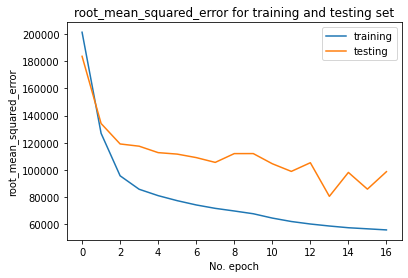

In [75]:
# plot learning curves
plt.plot(history.history['root_mean_squared_error'], label='training')
plt.plot(history.history['val_root_mean_squared_error'], label='testing')
plt.ylabel('root_mean_squared_error')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.title('root_mean_squared_error for training and testing set')
plt.show()

####**e) Using the model from the best epoch, report the test R2 value and show the top 30 test samples with the largest errors. List down any trends you find in these samples and suggest ways to reduce these errors. (Tip: Add the prediction error as a column in the DataFrame and sort by it.)**

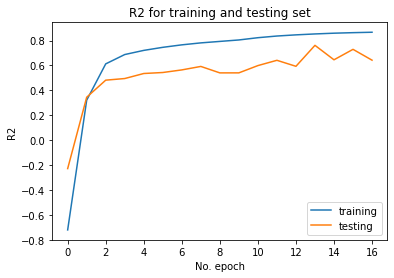

In [93]:
# plot learning curves
plt.plot(history.history['r2'], label='training')
plt.plot(history.history['val_r2'], label='testing')
plt.ylabel('R2')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.title('R2 for training and testing set')
plt.show()

In [219]:
df_list = []
for example, label in test_ds:
  y_pred = model.predict(example)
  df = pd.DataFrame.from_records(example)
  df['resale_price'] = label
  df['mse'] = tf.keras.metrics.mean_squared_error(label, y_pred)
  df_list.append(df)

In [220]:
mse_df = pd.concat(df_list, ignore_index=True)

In [225]:
top30_df = mse_df.sort_values(by=['mse'], ascending=False)[:30]
top30_df

,degree_centrality,dist_to_dhoby,dist_to_nearest_stn,eigenvector_centrality,flat_model_type,floor_area_sqm,month,remaining_lease_years,storey_range,year,resale_price,mse
15334,0.016807,3.882019,0.584731,0.008342,"b'5 ROOM, Premium Apartment Loft'",122.0,12,93.333333,b'40 TO 42',2021,1328000.00,4.554790e+11
6221,0.033613,2.413099,0.352779,0.121082,"b'5 ROOM, Type S2'",106.0,12,88.083333,b'43 TO 45',2021,1254000.00,4.393883e+11
14003,0.033613,2.413099,0.352779,0.121082,"b'5 ROOM, Type S2'",106.0,7,88.583333,b'40 TO 42',2021,1225000.00,4.358425e+11
17484,0.033613,2.413099,0.352779,0.121082,"b'5 ROOM, Type S2'",108.0,2,89.000000,b'34 TO 36',2021,1138000.00,4.336634e+11
15812,0.033613,2.413099,0.352779,0.121082,"b'5 ROOM, Type S2'",107.0,12,88.083333,b'40 TO 42',2021,1288000.00,4.287221e+11
40770,0.016807,3.882019,0.584731,0.008342,"b'5 ROOM, Premium Apartment Loft'",122.0,7,92.833333,b'37 TO 39',2022,1418000.00,4.268003e+11
17476,0.033613,2.546116,0.450314,0.121082,"b'5 ROOM, Type S2'",105.0,3,87.916667,b'46 TO 48',2022,1348888.00,4.239929e+11
7779,0.033613,2.546116,0.450314,0.121082,"b'5 ROOM, Type S2'",105.0,1,89.000000,b'43 TO 45',2021,1120000.00,4.199000e+11
35749,0.033613,2.445314,0.401367,0.121082,"b'5 ROOM, Type S2'",106.0,11,88.333333,b'40 TO 42',2021,1261000.00,4.190782e+11
37619,0.033613,2.413099,0.352779,0.121082,"b'5 ROOM, Type S2'",107.0,2,87.916667,b'46 TO 48',2022,1308000.00,4.167464e+11


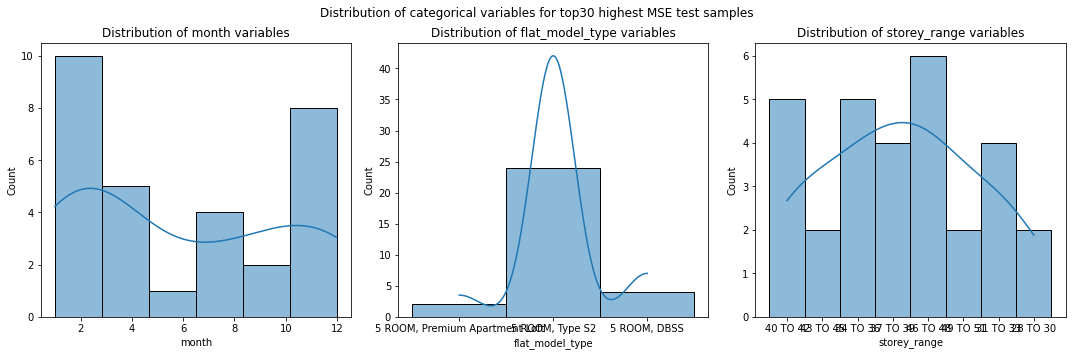

In [231]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(categoricalDict.keys(), axes):
    sns.histplot(data=top30_df[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of categorical variables for top30 highest MSE test samples')
plt.show()

Based on the distribution plot of categorical variables, we can observe that most of the high-error samples comes from 5 ROOM flat_model_type. Our model may not well-consider flat_model_type or specifically, the 5-ROOM type due to the number of instances of such type.

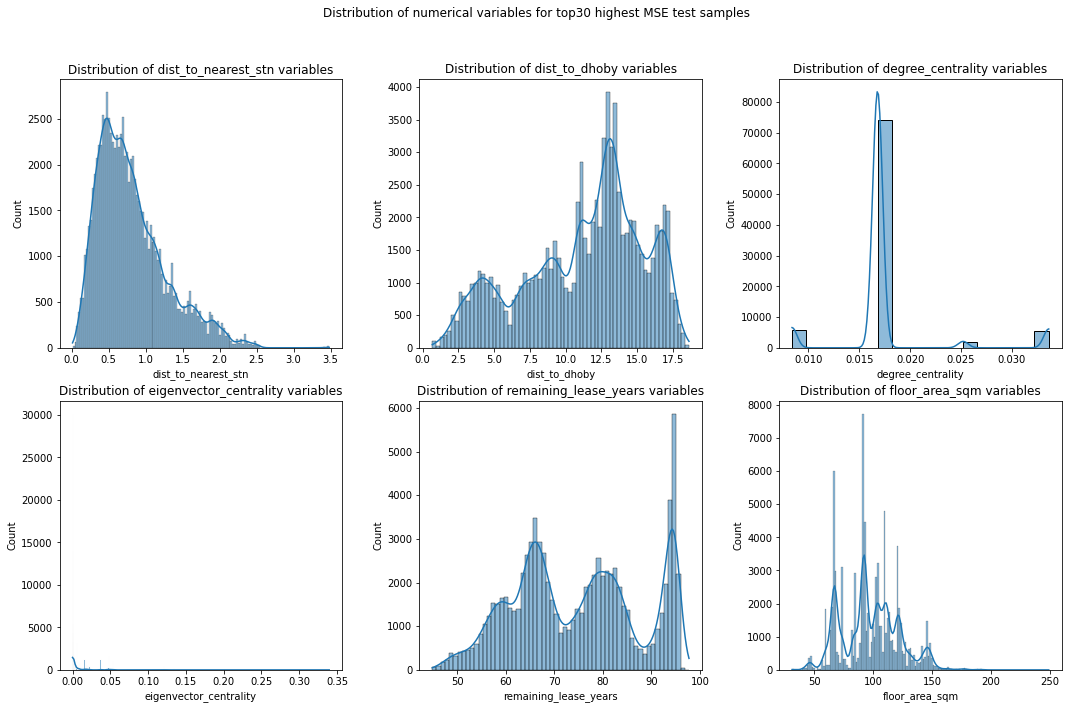

In [229]:
fig, axes = plt.subplots(len(numericList)//3, 3, figsize=(15, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(numericList, axes):
    sns.histplot(data=train_dataframe[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of numerical variables for top30 highest MSE test samples')
plt.show()

From numerical variables' plot, our top30 samples almost have the similar degree_centrality around 0.017 and from-0-to-1 distance to nearest station.

To reduce such errors, we should add more data for 5-ROOM type and degree_centrality ranged from 0.015 to 0.020 instances to train the model. Other than that, we also can increase the complexity of model architecture by adding more hidden layers to increase power of model.